# Loan Prediction: Model Training, Evaluation, and Pipeline

This notebook covers the end-to-end process for the loan prediction model.
1.  **Model Training & Evaluation**: We load the dataset, preprocess it, train a Logistic Regression model, and evaluate its performance.
2.  **Full Prediction Pipeline**: We use the trained model in a simulation that uses our API to fetch data and log a prediction.

In [60]:
#Imports and Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import joblib
import os
from dotenv import load_dotenv

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Load environment variables from .env file
load_dotenv()
print("Libraries imported and environment loaded.")

Libraries imported and environment loaded.


## Part 1: Model Training and Evaluation

In [61]:
#Load and Preprocess the Data
try:
    df = pd.read_csv('../data/Phase2.csv')
    print("Dataset loaded successfully.")
    df.dropna(inplace=True)
except FileNotFoundError:
    print("Error: 'data/Phase2.csv' not found.")

# Convert categorical columns to numerical using one-hot encoding
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define Features (X) and Target (y)
y = df_processed['loan_status']
X = df_processed.drop('loan_status', axis=1)

print("\nData Preprocessing Complete.")

Dataset loaded successfully.

Data Preprocessing Complete.


In [62]:
#Split Data and Scale Features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split and scaled.")

Data split and scaled.


In [63]:
# Train Model and Save Pipeline Assets
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)
print("Model training complete.")

# Save all assets needed for the pipeline in one file
pipeline_assets = {
    'model': model,
    'scaler': scaler,
    'columns': X.columns.tolist() # Save the column order
}
joblib.dump(pipeline_assets, 'saved_model/pipeline_assets.joblib')
print("Trained model, scaler, and columns saved to 'ml/saved_model/pipeline_assets.joblib'.")

Model training complete.
Trained model, scaler, and columns saved to 'ml/saved_model/pipeline_assets.joblib'.


--- Classification Report (Threshold = 0.75) ---
              precision    recall  f1-score   support

Rejected (0)       0.94      0.93      0.93      6999
Approved (1)       0.75      0.78      0.77      2000

    accuracy                           0.89      8999
   macro avg       0.84      0.85      0.85      8999
weighted avg       0.90      0.89      0.89      8999


--- Confusion Matrix (Threshold = 0.75) ---


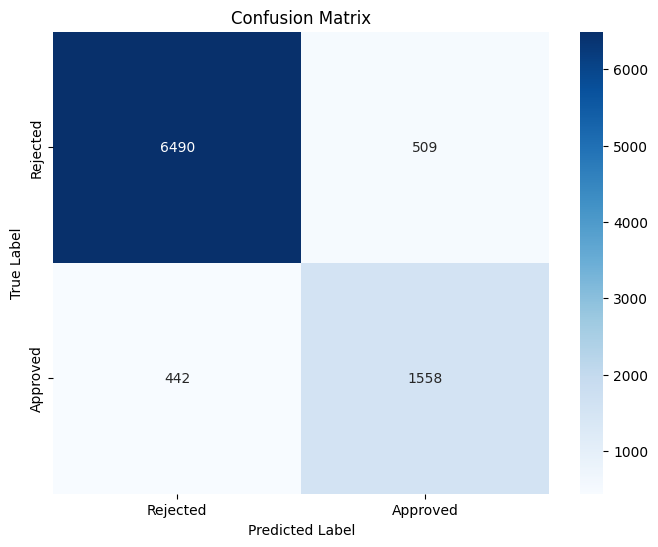

In [64]:
# Evaluate Model Performance with an Adjustable Threshold

# --- NEW: Define your decision threshold ---
# Default is 0.5. Raise it to reduce False Positives (be stricter).
# Lower it to reduce False Negatives (be more lenient).
decision_threshold = 0.75 

# --- NEW: Get probabilities instead of direct predictions ---
# This gets the probability for the 'Approved' class (the second column)
y_pred_probs = model.predict_proba(X_test_scaled)[:, 1]

# --- NEW: Apply the threshold to get the final predictions ---
y_pred = (y_pred_probs >= decision_threshold).astype(int)


# --- Classification Report ---
print(f"--- Classification Report (Threshold = {decision_threshold}) ---")
# Use names that match the final decision
print(classification_report(y_test, y_pred, target_names=['Rejected (0)', 'Approved (1)']))


# --- Confusion Matrix ---
print(f"\n--- Confusion Matrix (Threshold = {decision_threshold}) ---")
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix with the corrected labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Approved'], 
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Part 2: Full Prediction Pipeline
This section runs the final pipeline to fetch data from the API and log a prediction.

In [65]:
API_URL = "http://127.0.0.1:8000"

# Input IDs
person_id = int(input("Enter Person ID: "))
loan_id = int(input("Enter Loan ID: "))

# Fetch person data from API
response = requests.get(f"{API_URL}/persons/{person_id}")
response.raise_for_status()
person_data = response.json()

# Find the matching loan by ID
loan = next((l for l in person_data["loans"] if l["loan_id"] == loan_id), None)
if not loan:
    raise ValueError(f"Loan ID {loan_id} not found for person {person_id}")
if loan["loan_status"].lower() != "pending":
    raise ValueError(f"Loan ID {loan_id} is not 'Pending' (got '{loan['loan_status']}')")

# Assign to variables for prediction
person = person_data

In [66]:
# Load model assets
ASSETS_PATH = "saved_model/pipeline_assets.joblib"
assets = joblib.load(ASSETS_PATH)

model = assets["model"]
scaler = assets["scaler"]
training_columns = assets["columns"]


In [67]:
# Define mapping and processing logic
ownership_map = {0: "RENT", 1: "OWN", 2: "MORTGAGE"}
input_df = pd.DataFrame(columns=training_columns, index=[0]).fillna(0)

# Person features
input_df.loc[0, 'person_age'] = person['age']
input_df.loc[0, 'person_income'] = person['income']
input_df.loc[0, 'person_home_ownership'] = ownership_map.get(person['home_ownership_id'], "RENT")
input_df.loc[0, 'person_emp_length'] = person['employment_experience']
input_df.loc[0, 'cb_person_default_on_file'] = "Y" if person['credit_score'] < 650 else "N"
input_df.loc[0, 'cb_person_cred_hist_length'] = person['credit_history_length']

# Loan features
input_df.loc[0, 'loan_amnt'] = loan['loan_amount']
input_df.loc[0, 'loan_int_rate'] = float(loan['loan_interest_rate'])
input_df.loc[0, 'loan_percent_income'] = float(loan['loan_amount']) / float(person['income'])

input_df


/var/folders/rc/4dk0zlk5187f_18nfp0ywg8h0000gn/T/ipykernel_97695/3146392724.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = pd.DataFrame(columns=training_columns, index=[0]).fillna(0)
/var/folders/rc/4dk0zlk5187f_18nfp0ywg8h0000gn/T/ipykernel_97695/3146392724.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.loc[0, 'loan_int_rate'] = float(loan['loan_interest_rate'])
/var/folders/rc/4dk0zlk5187f_18nfp0ywg8h0000gn/T/ipykernel_97695/3146392724.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. V

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender_male,person_education_bachelor,...,person_home_ownership_rent,loan_intent_education,loan_intent_homeimprovement,loan_intent_medical,loan_intent_personal,loan_intent_venture,previous_loan_defaults_on_file_yes,person_home_ownership,person_emp_length,cb_person_default_on_file
0,45,180000,0,50000,5.5,0.277778,22,0,0,0,...,0,0,0,0,0,0,0,RENT,20.0,N
